In [29]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [30]:
# pairList = pairJson['hitbtc2018']
pair = 'BTC/USDT'
timeframe = '1h'
startDate = '2017-07-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 39409 candles for BTCUSDT


In [31]:
# -- Indicator variable --
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['MA_50'] = ta.trend.ema_indicator(close=df['close'], window=50)
df['MA_200'] = ta.trend.ema_indicator(close=df['close'], window=200)
df['MA_600'] = ta.trend.ema_indicator(close=df['close'], window=600)
df['MACD'] = ta.trend.macd(close=df['close'])
df['MACD_SIGNAL'] = ta.trend.macd_signal(close=df['close'])
df['ADX_POS'] = ta.trend.adx_pos(high=df['high'], low=df['low'], close=df['close'])
df['ADX_NEG'] = ta.trend.adx_neg(high=df['high'], low=df['low'], close=df['close'])

df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,MA_50,MA_200,MA_600,MACD,MACD_SIGNAL,ADX_POS,ADX_NEG,STOCH_RSI
timestamp,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-19 06:00:00,40237.76,40444.32,40208.67,40370.01,713.364020,41012.574547,42175.119883,41635.988627,-218.339154,-320.990620,14.258955,20.312933,1.000000
2022-02-19 07:00:00,40370.01,40407.31,40241.86,40263.71,503.584900,40983.207310,42156.100880,41631.421976,-197.233068,-296.239109,13.738715,19.571813,0.795762
2022-02-19 08:00:00,40263.70,40301.11,39933.83,39976.14,840.666240,40943.714474,42134.409726,41625.913550,-201.389347,-277.269157,12.636520,24.729999,0.326185


In [32]:
# -- Intern parameter --
# dfTest = df['2017-10-24':'2018-01-31']
dfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.82
stochOverSold = 0.2
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if row['close'] > row['MA_50'] and row['close'] > row['MA_200'] and row['close'] > row['MA_600'] and row['MACD'] > row['MACD_SIGNAL'] and row['ADX_POS'] > row['ADX_NEG'] and row['STOCH_RSI'] < 0.80:
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if row['MACD'] < row['MACD_SIGNAL'] and row['ADX_POS'] < row['ADX_NEG'] and row['STOCH_RSI'] > 0.20:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 18439.97398291637


In [33]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : BTC/USDT | Timeframe : 1h
Period : [2017-08-17 04:00:00] -> [2022-02-19 10:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 18439.97 $
Performance vs US Dollar : 1745.29 %
Buy and Hold Performence : 824.24 %
Performance vs Buy and Hold : 99.66 %
Best trade : +26.08 %, the 2017-12-08 14:00:00
Worst trade : -11.12 %, the 2021-09-07 19:00:00
Worst drawDown : - 24.45 %
Total fees :  5071.78 $

----- Trades Informations -----
Total trades on period : 407
Number of positive trades : 161
Number of negative trades :  246
Trades win rate ratio : 39.56 %
Average trades performance : 0.88 %
Average positive trades : 4.27 %
Average negative trades : -1.34 %

----- Time Informations -----
Average time duration for a trade : 26.11 periods
Maximum time duration for a trade : 138 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 70.55 periods
Maximum time duration between two trades : 1255 periods
Minimum t

----- 2017 Performances: 228.01% -----


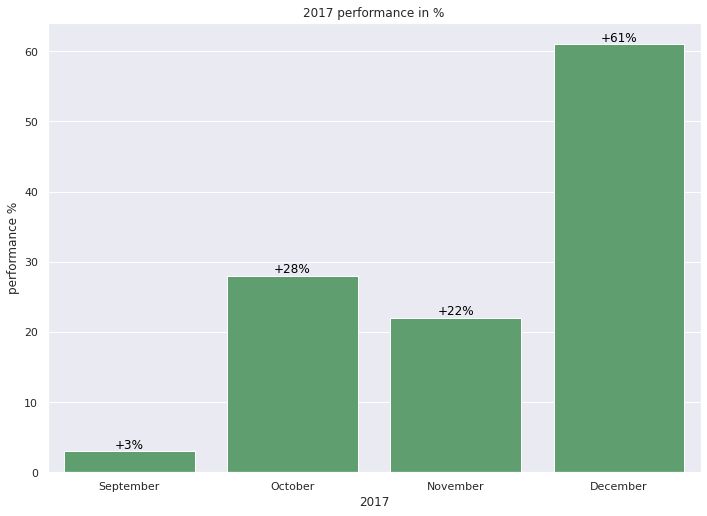

----- 2018 Performances: 10.16% -----


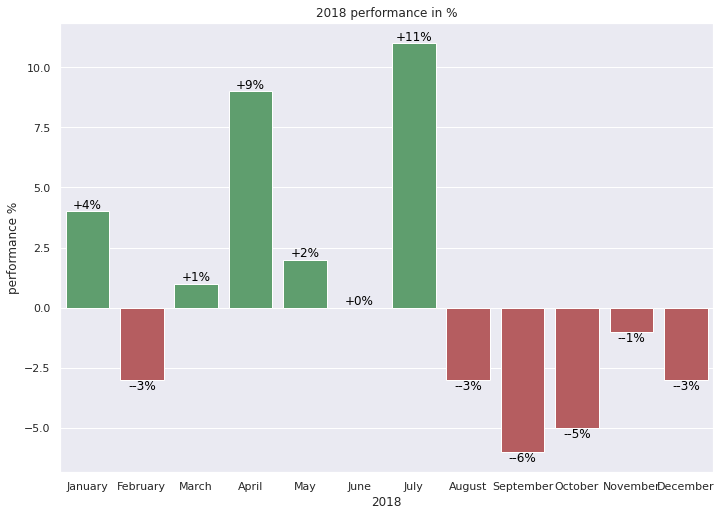

----- 2019 Performances: 64.32% -----


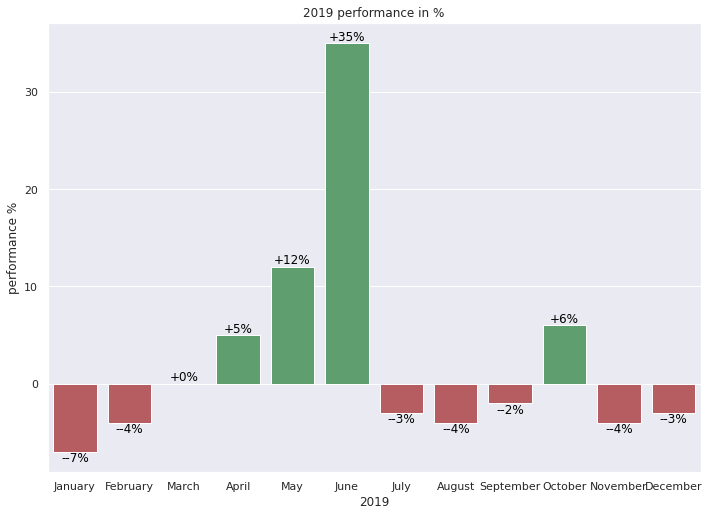

----- 2020 Performances: 152.81% -----


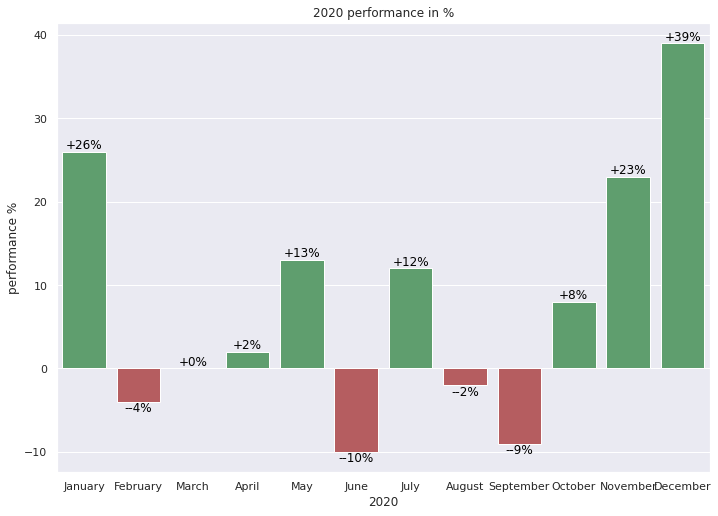

----- 2021 Performances: 20.46% -----


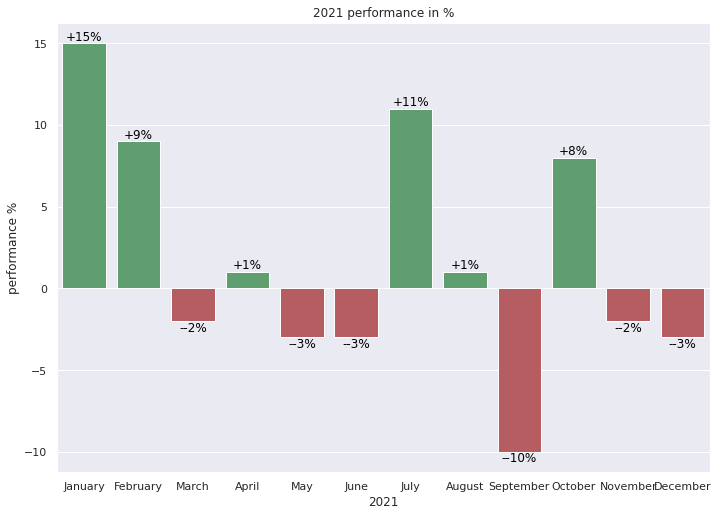

----- 2022 Performances: 2.41% -----


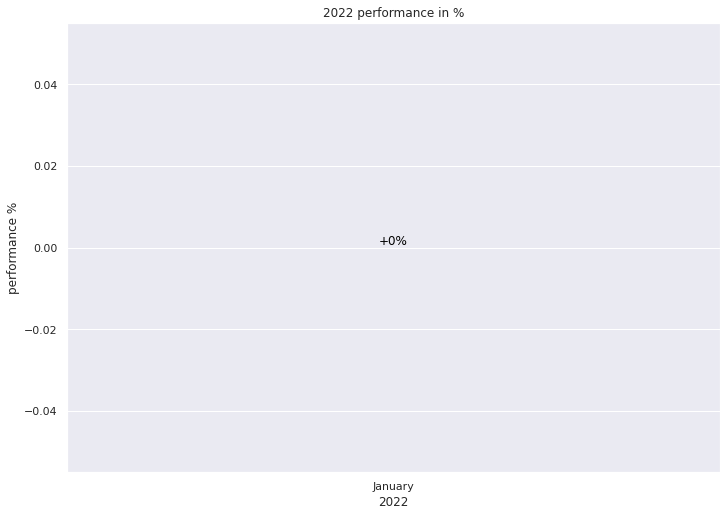

In [34]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


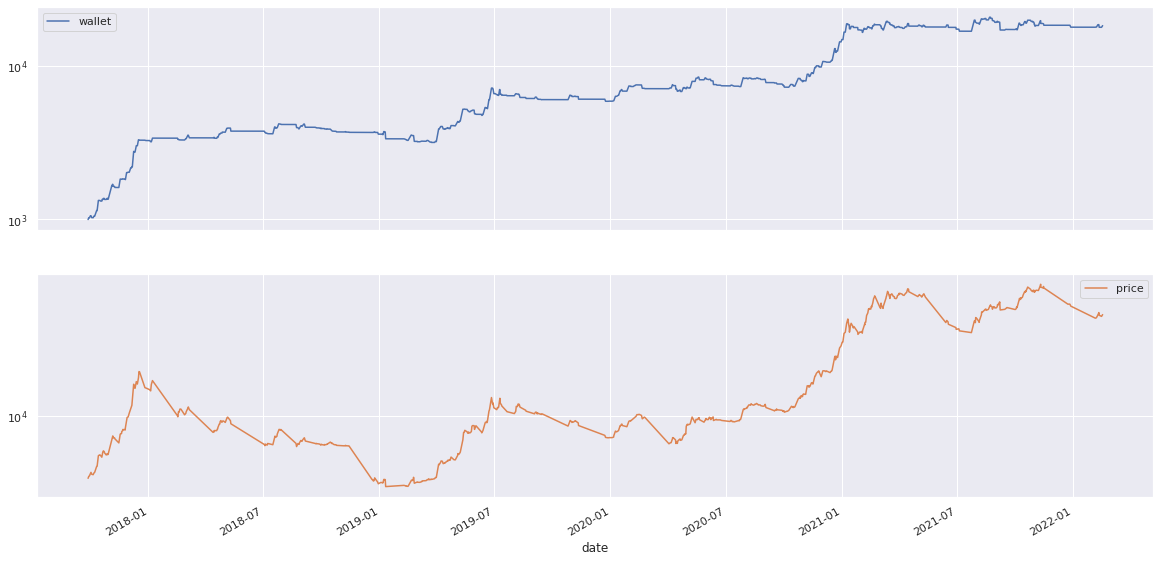

In [35]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)